In [1]:
# import functions
# OS interaction and time
import os
import sys
import cftime
import datetime
import time
import glob
import dask
import dask.bag as db
import calendar

# math and data
import numpy as np
import netCDF4 as nc
import xarray as xr
import scipy as sp
from scipy.signal import detrend
import pandas as pd
import pickle as pickle
from sklearn import linear_model
import matplotlib.patches as mpatches
from shapely.geometry.polygon import LinearRing
import statsmodels.stats.multitest as multitest

# plotting
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import ticker
import matplotlib.colors as mcolors
from matplotlib.gridspec import GridSpec

from matplotlib.ticker import FormatStrFormatter
from mpl_toolkits.axes_grid1.axes_divider import HBoxDivider
import mpl_toolkits.axes_grid1.axes_size as Size
from mpl_toolkits.axes_grid1 import make_axes_locatable

import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.util import add_cyclic_point

# random
from IPython.display import display
from IPython.display import HTML
import IPython.core.display as di # Example: di.display_html('<h3>%s:</h3>' % str, raw=True)

In [2]:
my_era5_path = '/glade/u/home/zcleveland/scratch/ERA5/'  # path to subset data
my_corr_path = '/glade/u/home/zcleveland/scratch/ERA5/correlations/'  # path to my correlation datasets
cp_in_path = '/glade/u/home/zcleveland/scratch/ERA5/cp/'  # path to subset CP data
sub_script_path = '/glade/u/home/zcleveland/NAM_soil-moisture/ERA5_analysis/scripts/subsetting/'  # path to subsetting scripts
plot_script_path = '/glade/u/home/zcleveland/NAM_soil-moisture/ERA5_analysis/scripts/plotting/'  # path to plotting scripts
plot_out_path = '/glade/u/home/zcleveland/NAM_soil-moisture/ERA5_analysis/plots/correlations/'  # path to generated figures
temp_scratch_path = '/glade/u/home/zcleveland/NAM_soil-moisture/ERA5_analysis/temp/'  # path to temp directory in scratch

In [3]:
# Variable lists
# surface instantaneous variables
sfc_instan_list = [
    'sd',  # snow depth  (m of water equivalent)
    'msl',  # mean sea level pressure (Pa)
    'tcc',  # total cloud cover (0-1)
    'stl1',  # soil temp layer 1 (K)
    'stl2',  # soil temp layer 2 (K)
    'stl3',  # soil temp layer 3 (K)
    'stl4',  # soil temp layer 4 (K)
    'swvl1',  # soil volume water content layer 1 (m^3 m^-3)
    'swvl2',  # soil volume water content layer 2 (m^3 m^-3)
    'swvl3',  # soil volume water content layer 3 (m^3 m^-3)
    'swvl4',  # soil volume water content layer 4 (m^3 m^-3)
    '2t',  # 2 meter temp (K)
    '2d',  # 2 meter dew point (K)
    'ishf',  # instant surface heat flux (W m^-2)
    'ie',  # instant moisture flux (kg m^-2 s^-1)
    'cape',  # convective available potential energy (J kg^-1)
    'tcw',  # total column water (kg m^-2) -- sum total of solid, liquid, and vapor in a column
    'sstk',  # sea surface temperature (K)
    'vipile',  # vertical integral of potential, internal, and latent energy (J m^-2) - instan
    'viwve',  # vertical integral of eastward water vapour flux (kg m^-1 s^-1) - instan -- positive south -> north
    'viwvn',  # vertical integral of northward water vapour flux (kg m^-1 s^-1) - instan -- positive west -> east
    'viwvd',  # vertical integral of divergence of moisture flux (kg m^-2 s^-1) - instan -- positive divergencve
]

# surface accumulation variables
sfc_accumu_list = [
    'lsp',  # large scale precipitation (m of water)
    'cp',  # convective precipitation (m of water)
    'tp',  # total precipitation (m of water) -- DERIVED
    'sshf',  # surface sensible heat flux (J m^-2)
    'slhf',  # surface latent heat flux (J m^-2)
    'ssr',  # surface net solar radiation (J m^-2)
    'str',  # surface net thermal radiation (J m^-2)
    'sro',  # surface runoff (m)
    'sf',  # total snowfall (m of water equivalent)
    'ssrd',  # surface solar radiation downwards (J m^-2)
    'strd',  # surface thermal radiation downwards (J m^-2)
    'ttr',  # top net thermal radiation (OLR, J m^-2) -- divide by time (s) for W m^-2
]

# pressure level variables
pl_var_list = [
    # 'pv',  # potential vorticity (K m^2 kg^-1 s^-1)
    # 'crwc',  # specific rain water content (kg kg^-1)
    # 'cswc',  # specific snow water content (kg kg^-1)
    'z',  # geopotential (m^2 s^2)
    't',  # temperature (K)
    'u',  # u component of wind(m s^-1)
    'v',  # v component of wind (m s^-1)
    'q',  # specific humidity (kg kg^-1)
    'w',  # vertical velo|city (Pa s^-1)
    # 'vo',  # vorticity - relative (s^-1)
    # 'd',  # divergence (s^-1)
    'r',  # relative humidity (%)
    # 'clwc',  # specific cloud liquid water content
    # 'ciwc',  # specific cloud ice water content
    # 'cc',  # fraction of cloud cover (0-1)
]

# NAM variables
NAM_var_list = [
    'onset',
    'retreat',
    'length'
]

# all var in one list
var_list = sfc_instan_list + sfc_accumu_list + pl_var_list

# region average list
region_avg_list = [
    'cp',
    'mr',
    'son',
    'chi',
    'moj',
    'MeNmAz',
]

# variables that are fluxes and need to be multiplied by -1 for easier understanding
flux_var_list = [
    'sshf',  # surface sensible heat flux (J m^-2)
    'slhf',  # surface latent heat flux (J m^-2)
    'ttr',  # top net thermal radiation (OLR, J m^-2) -- divide by time (s) for W m^-2
    'ishf',  # instant surface heat flux (W m^-2)
    'ie',  # instant moisture flux (kg m^-2 s^-1)
]

In [4]:
# Variable dictionaries

# dictionary of variables and their names
var_dict = {
    'sd': 'Snow Depth',
    'msl': 'Mean Sea Level Pressure',
    'tcc': 'Total Cloud Cover',
    'stl1': 'Soil Temp Layer 1',
    'stl2': 'Soil Temp Layer 2',
    'stl3': 'Soil Temp Layer 3',
    'stl4': 'Soil Temp Layer 4',
    'swvl1': 'Soil Volume Water Content Layer 1',
    'swvl2': 'Soil Volume Water Content Layer 2',
    'swvl3': 'Soil Volume Water Content Layer 3',
    'swvl4': 'Soil Volume Water Content Layer 4',
    '2t': '2 Meter Temp',
    '2d': '2 Meter Dew Point',
    'ishf': 'Instant Surface Heat Flux',
    'ie': 'Instant Moisture Flux',
    'cape': 'Convective Available Potential Energy',
    'tcw': 'Total Column Water',
    'sstk': 'Sea Surface Temperature',
    'vipile': 'vertical integral of potential, internal, and latent energy',
    'viwve': 'vertical integral of eastward water vapour flux',
    'viwvn': 'vertical integral of northward water vapour flux',
    'viwvd': 'vertical integral of divergence of moisture flux',
    'lsp': 'Large Scale Precipitation',
    'cp': 'Convective Precipitation',
    'tp': 'Total Precipitation',
    'sshf': 'Surface Sensible Heat Flux',
    'slhf': 'Surface Latent Heat Flux',
    'ssr': 'Surface Net Solar Radiation',
    'str': 'Surface Net Thermal Radiation',
    'sro': 'Surface Runoff',
    'sf': 'Total Snowfall',
    'ssrd': 'Surface Solar Radiation Downwards',
    'strd': 'Surface Thermal Radiation Downwards',
    'ttr': 'Top Net Thermal Radiation (OLR)',
    'z': 'Geopotential',
    't': 'Temperature',
    'u': 'U Component of Wind',
    'v': 'V Component of Wind',
    'q': 'Specific Humidity',
    'w': 'Vertical Velocity',
    'r': 'Relative Humidity',
    'onset': 'Onset',
    'retreat': 'Retreat',
    'length': 'Length'
}

# variable units in latex format for plotting
var_units = {
    'sd': '(m)',
    'msl': '(Pa)',
    'tcc': '(0-1)',
    'stl1': '(K)',
    'stl2': '(K)',
    'stl3': '(K)',
    'stl4': '(K)',
    'swvl1': '$(m^3 m^{-3})$',
    'swvl2': '$(m^3 m^{-3})$',
    'swvl3': '$(m^3 m^{-3})$',
    'swvl4': '$(m^3 m^{-3})$',
    '2t': '(K)',
    '2d': '(K)',
    'ishf': '$(W m^{-2})$',
    'ie': '$(kg m^{-2} s^{-1})$',
    'cape': '$(J kg^{-1})$',
    'tcw': '$(kg m^{-2})$',
    'sstk': '(K)',
    'vipile': '$(J m^{-2})$',
    'viwve': '$(kg m^{-1} s^{-1})$',
    'viwvn': '$(kg m^{-1} s^{-1})$',
    'viwvd': '$(kg m^{-2} s^{-1})$',
    'lsp': '(m)',
    'cp': '(m)',
    'tp': '(m)',
    'sshf': '$(J m^{-2})$',
    'slhf': '$(J m^{-2})$',
    'ssr': '$(J m^{-2})$',
    'str': '$(J m^{-2})$',
    'sro': '(m)',
    'sf': '(m)',
    'ssrd': '$(J m^{-2})$',
    'strd': '$(J m^{-2})$',
    'ttr': '$(J m^{-2})$',
    'z': '$(m^2 s^{-2})$',
    't': '(K)',
    'u': '$(m s^{-1})$',
    'v': '$(m s^{-1})$',
    'q': '$(kg kg^{-1})$',
    'w': '$(Pa s^{-1})$',
    'r': '(%)',
    'onset': '',
    'retreat': '',
    'length': ''
}

# dictionary of regions and their names
region_avg_dict = {
    'cp': 'Colorado Plateau',
    'mr': 'Mogollon Rim',
    'son': 'Sonoran Desert',
    'chi': 'Chihuahuan Desert',
    'moj': 'Mojave Desert',
    'MeNmAz': 'Mexico, New Mexico, and Arizona Border',
}

# dictionary of regions and their coordinate boundaries
# [WEST, EAST, NORTH, SOUTH] -- WEST and EAST are on 0-360 latitude grid system
region_avg_coords = {
    'cp': [249, 253, 39, 35],
    'mr': [249, 251, 34, 33],
    'son': [246, 250, 32, 28],
    'chi': [252, 256, 33, 29],
    'moj': [243, 247, 37, 33],
    'MeNmAz': [246, 256, 38, 28],
}

In [142]:
# define main funciton to execute plotting based on type
def main(var1='swvl1', var1_month_list=[3, 4, 5], var1_region='cp',
         var2='tp', var2_month_list=[6, 7, 8], var2_region='dsw',
         detrend_flag=True, overwrite_flag=False, **kwargs):

    # months list
    var1_months = month_num_to_name(var=var1, months=var1_month_list)
    var2_months = month_num_to_name(var=var2, months=var2_month_list)

    # in/out file name and paths
    in_fn, in_fp, out_fn, out_fp = get_fn_fp(var1, var1_months, var1_region,
                                             var2, var2_months, var2_region,
                                             detrend_flag, **kwargs)

    # check existence of input file
    if not os.path.exists(in_fp):
        print(f'corr file not found : {in_fp}')
        return

    # check existence of file already
    if os.path.exists(out_fp):
        print(f'File already exists for: {out_fn}', end=' - ')
        if not overwrite_flag:
            print('overwrite_flag is False. Skipping . . .')
            return
        else:
            print('overwrite_flag is True. Overwriting . . .')

    # open dataset
    ds = xr.open_dataset(in_fp)
    corr_da = ds['pearson_r']
    pval_da = ds['p_value']

    # check if var is a flux and need to be flipped
    if ((var1 in flux_var_list) or (var2 in flux_var_list)):
        print(f'plotting flux\t-\tvar1: {var1}\t-\tvar2:{var2}')
        print(f'old corr_da avg: {corr_da.mean().compute()}')
        corr_da = corr_da * -1
        print(f'new corr_da avg: {corr_da.mean().compute()}')

    # plot the results
    if ((var1_region == 'dsw') or (var2_region == 'dsw')):
        plot_2d_correlation_dsw(corr_da, pval_da)
    elif ((var1_region == 'global') or (var2_region == 'global')):
        plot_2d_correlation_global(corr_da, pval_da)

    # plot features
    # plt.title(f'Correlation Between \n{var_dict[var1]} ({var1_months}, {var1_region}) \n& {var_dict[var2]} ({var2_months}, {var2_region})')
    plt.tight_layout()
    plt.savefig(out_fp, dpi=300, bbox_inches='tight')
    # plt.show()
    plt.close()

    # return ds

In [131]:
# define a function to plot 2d map of correlations for dsw
def plot_2d_correlation_dsw(corr_da, pval_da):

    projection = ccrs.PlateCarree()
    fig, ax = plt.subplots(figsize=(10, 6), subplot_kw=dict(projection=projection))

    # create contour levels and hatches for plotting
    corr_levels = np.arange(-1, 1.05, 0.05)

    # plot the data using contourf
    corr_cf = plt.contourf(corr_da.longitude, corr_da.latitude,
                           corr_da, levels=corr_levels,
                           cmap='RdBu_r', extend='both')

    # extract coordinates where p-value < 0.1 (dots) and p-value < 0.05 (triangles)
    lat, lon = np.meshgrid(pval_da.latitude, pval_da.longitude, indexing='ij')
    mask_dots = (pval_da <= 0.1) & (pval_da >= 0.05)
    mask_triangles = pval_da <= 0.05

    # Plot dots (p-value < 0.1 and >= 0.05)
    plt.scatter(lon[mask_dots], lat[mask_dots], color='black', marker='.',
                s=5, transform=ccrs.PlateCarree(), label='0.05 <= p < 0.1')

    # Plot triangles (p-value < 0.05)
    plt.scatter(lon[mask_triangles], lat[mask_triangles], color='black', marker='^',
                s=8, transform=ccrs.PlateCarree(), label='p < 0.05')

    # add coastlines, state borders, and other features
    ax.coastlines(linewidth=0.5)
    ax.add_feature(cfeature.BORDERS, linestyle=':', linewidth=0.5)
    ax.add_feature(cfeature.STATES, linewidth=0.5)

    # plt.colorbar(corr_cf, ax=ax, label='Pearson Correlation Coefficient', pad=0.02)
    # plt.legend(bbox_to_anchor=(1, 1, 0.25, 0.15))

In [140]:
def count_neighbors_below_threshold(da, threshold):
    # create a mask where values are below the threshold
    mask_below_threshold = da < threshold

    # create a mask for the borders of the grid
    border_mask = np.ones_like(da, dtype=bool)
    border_mask[1:-1, 1:-1] = False

    # count the number of neighbors below the threshold for each point
    num_neighbors = np.zeros_like(da, dtype=int)
    for i in range(-1, 2):
        for j in range(-1, 2):
            if i == 0 and j == 0:  # exclude central point from calculation
                continue
            num_neighbors += mask_below_threshold.shift(latitude=i, longitude=j, fill_value=False).values

    # exclude the borders from the count
    num_neighbors[border_mask] = 0

    return num_neighbors


# define a function to plot 2d map of correlations for global
def plot_2d_correlation_global(corr_da, pval_da):

    projection = ccrs.PlateCarree(central_longitude=180)
    fig, ax = plt.subplots(figsize=(10, 6), subplot_kw=dict(projection=projection))

    # create contour levels and hatches for plotting
    corr_levels = np.arange(-1, 1.05, 0.05)

    # plot the data using contourf
    corr_cf = plt.contourf(corr_da.longitude, corr_da.latitude,
                           corr_da, levels=corr_levels,
                           cmap='RdBu_r', extend='both', transform=ccrs.PlateCarree())

    # parse lats/lons to declutter plot
    lat, lon = np.meshgrid(pval_da.latitude[::10], pval_da.longitude[::20], indexing='ij')

    # count the number of neighbors below the p-value thresholds for each point
    num_neighbors_below_0p1 = count_neighbors_below_threshold(pval_da, 0.1)
    num_neighbors_below_0p05 = count_neighbors_below_threshold(pval_da, 0.05)

    # create mask for dots and triangles
    mask_dots = (num_neighbors_below_0p1[::10, ::20] >= 4)
    mask_triangles = (num_neighbors_below_0p05[::10, ::20] >= 4)

    # Plot dots (p-value < 0.1 and >= 0.05)
    plt.scatter(lon[mask_dots], lat[mask_dots], color='black', marker='.',
                s=2, transform=ccrs.PlateCarree(), label='0.05 <= p < 0.1')

    # Plot triangles (p-value < 0.05)
    plt.scatter(lon[mask_triangles], lat[mask_triangles], color='black', marker='^',
                s=4, transform=ccrs.PlateCarree(), label='p < 0.05')

    # add coastlines, state borders, and other features
    ax.coastlines(linewidth=0.5)
    ax.add_feature(cfeature.BORDERS, linestyle=':', linewidth=0.5)
    ax.add_feature(cfeature.STATES, linewidth=0.5)

    # plt.colorbar(corr_cf, ax=ax, label='Pearson Correlation Coefficient', pad=0.02)
    # plt.legend(bbox_to_anchor=(1, 1, 0.25, 0.15))

In [7]:
# define a function to turn a list of integers into months
def month_num_to_name(var, months):

    if var in NAM_var_list:
        var_months = ''
    elif len(months) == 1:
        var_months = calendar.month_name[months[0]]  # use full month name if only 1 month
    elif ((len(months) > 1) & (len(months) <= 12)):
        var_months = ''.join([calendar.month_name[m][0] for m in months])

    return var_months

In [8]:
# define a function to create and return the filename and
# file path for the input file and output plot
def get_fn_fp(var1, var1_months, var1_region,
               var2, var2_months, var2_region,
               detrend_flag, **kwargs):

    # check detrend_flag
    if detrend_flag:
        detrend_str = 'detrend'
    else:
        detrend_str = ''

    # create core of file name and in/out file name.
    # the .nc input file will match the .png output file
    fn_list = [str(var1), str(var1_months), str(var1_region),
               str(var2), str(var2_months), str(var2_region),
               str(detrend_str)]
    fn_core = '_'.join([i for i in fn_list if i != ''])

    in_fn = f'corr_{fn_core}.nc'
    out_fn = f'corr_{fn_core}.png'

    # create in and out file paths based on regions
    if var1_region == 'global':
        in_fp = os.path.join(my_corr_path, 'global', in_fn)
        out_fp = os.path.join(plot_out_path, 'global', out_fn)
    elif var2_region == 'dsw':
        in_fp = os.path.join(my_corr_path, 'dsw', in_fn)
        out_fp = os.path.join(plot_out_path, 'dsw', out_fn)
    elif var2_region in region_avg_list:
        in_fp = os.path.join(my_corr_path, 'regions', var2_region, in_fn)
        out_fp = os.path.join(plot_out_path, 'regions', var2_region, out_fn)

    return in_fn, in_fp, out_fn, out_fp

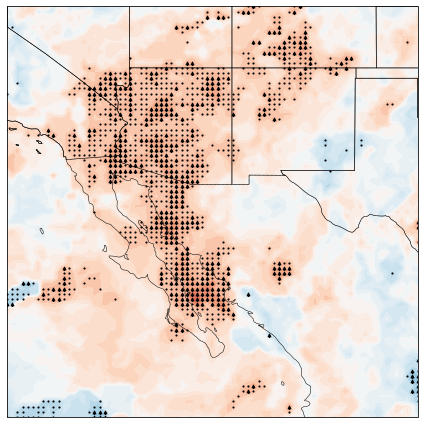

In [143]:
# # test cell -- dsw

# var1='swvl1'
# var1_month_list=[3, 4, 5]
# var1_region='cp'
# var2='onset'
# var2_month_list=[6, 7, 8]
# var2_region='dsw'
# detrend_flag=True
# overwrite_flag=False

# main(var1, var1_month_list, var1_region,
#      var2, var2_month_list, var2_region,
#      detrend_flag, overwrite_flag=True)

In [ ]:
# plot correlations for dsw
# calculate correlations for onset, retreat, length, and summer precipitation
var_list1 = sfc_accumu_list + sfc_instan_list + pl_var_list
var_list1.remove('sstk')
var_list2 = NAM_var_list + ['tp', 'vipile', 'viwve', 'viwvn', 'viwvd']
region_list = ['cp']
detrend_list = [True, False]
len_lists = len(var_list1)*len(var_list2)*len(region_list)*len(detrend_list)
cnt = 0
for var1 in var_list1:
    for var2 in var_list2:
        for region in region_list:
            for detrend_flag in detrend_list:
                with open(f'{plot_script_path}plot.txt', 'a') as file:
                    file.write(f'{var1}\t:\t{var2}\t:\t{region}\t:\tdetrend={detrend_flag}\t:\t{100*cnt/len_lists} %\n')
                # print(f'{var1}\t:\t{var2}\t:\t{region}\t:\tdetrend={detrend_flag}\t:\t{100*cnt/len_lists} %')
                main(var1=var1, var1_month_list=[3, 4, 5], var1_region=region, var1_level=700,
                     var2=var2, var2_month_list=[6, 7, 8], var2_region='dsw', var2_level=700,
                     detrend_flag=detrend_flag, overwrite_flag=False)
                cnt = cnt+1

plotting flux	-	var1: ttr	-	var2:onset
old corr_da avg: <xarray.DataArray 'pearson_r' ()>
array(0.04616691)
new corr_da avg: <xarray.DataArray 'pearson_r' ()>
array(-0.04616691)


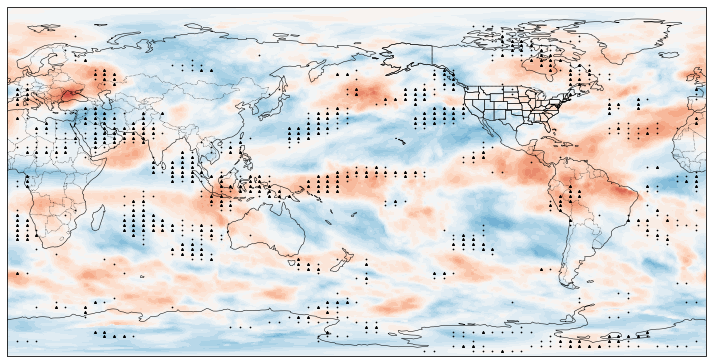

In [138]:
# # test cell -- global

# var1='ttr'
# var1_month_list=[3, 4, 5]
# var1_region='global'
# var2='onset'
# var2_month_list=[6, 7, 8]
# var2_region='MeNmAz'
# detrend_flag=True
# overwrite_flag=False

# main(var1, var1_month_list, var1_region,
#      var2, var2_month_list, var2_region,
#      detrend_flag, overwrite_flag)

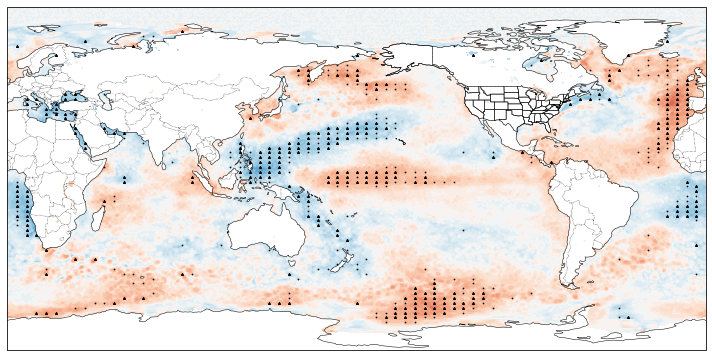

In [141]:
# # test cell -- global

# var1='sstk'
# var1_month_list=[3, 4, 5]
# var1_region='global'
# var2='onset'
# var2_month_list=[6, 7, 8]
# var2_region='MeNmAz'
# detrend_flag=True
# overwrite_flag=False
# main(var1, var1_month_list, var1_region,
#      var2, var2_month_list, var2_region,
#      detrend_flag, overwrite_flag)

In [ ]:
var_list1 = ['ttr', 'sstk']
var_list2 = NAM_var_list + ['tp', 'vipile', 'viwve', 'viwvn', 'viwvd']
var1_months_list = [
    [3, 4, 5],
    [6, 7, 8]
]
detrend_list = [True, False]
len_lists = len(var_list1)*len(var_list2)*len(var1_months_list)*len(detrend_list)
cnt = 0
start_time = time.time()
for var1 in var_list1:
    for var2 in var_list2:
        for var1_month_list in var1_months_list:
            for detrend_flag in detrend_list:
                # print(f'{var1}\t: {var2}\t: {var1_month_list}\t: detrend={detrend_flag}\t: {100*cnt/len_lists} %\t: time={time.time()-start_time}')
                with open(f'{plot_script_path}plot.txt', 'a') as file:
                    file.write(f'{var1}\t: {var2}\t: {var1_month_list}\t: detrend={detrend_flag}\t: {100*cnt/len_lists} %\t: time={time.time()-start_time}\n')

                main(var1=var1, var1_month_list=var1_month_list, var1_region='global',
                     var2=var2, var2_month_list=[6, 7, 8], var2_region='MeNmAz',
                     detrend_flag=detrend_flag, overwrite_flag=False)
                cnt=cnt+1